In [1]:
import pandas as pd
import numpy as np
import warnings
import gc

from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import KFold
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.utils.class_weight import compute_class_weight
from utils.reduce_memory import trainform_columns_type
from catboost import CatBoostClassifier

warnings.filterwarnings('ignore')



import matplotlib.pyplot as plt
import seaborn as sns

### 단일 값 가지는 컬럼 & NULL 값 가지는 컬럼 모두 제거.

In [2]:
train_df = pd.read_parquet('./data/train/train_filtered.parquet')
test_df = pd.read_parquet('./data/test/test_filtered.parquet')

# reduce memory by chaing data types of columns
train_df = trainform_columns_type(train_df)
test_df = trainform_columns_type(test_df)

print('shape of train dataset(drop colums)', train_df.shape)
print('shape of test dataset(drop colums)', test_df.shape)

shape of train dataset(drop colums) (2400000, 743)
shape of test dataset(drop colums) (600000, 742)


In [3]:
print(train_df['Segment'].value_counts())

Segment
E    1922052
D     349242
C     127590
A        972
B        144
Name: count, dtype: int64


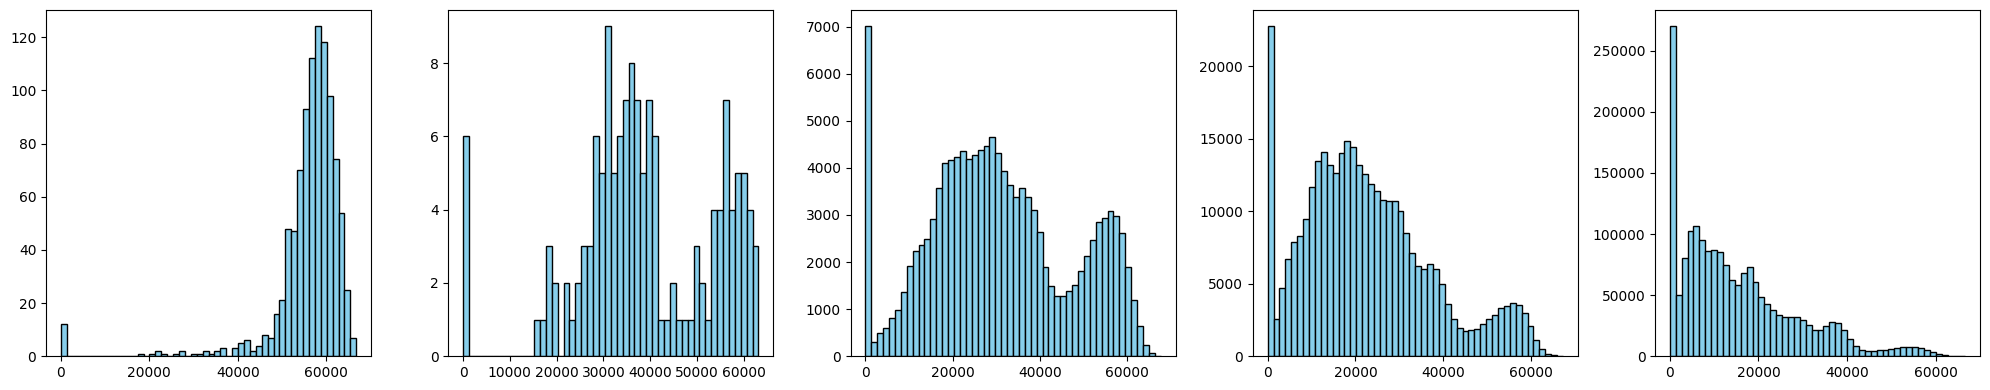

In [5]:
train_df = train_df[train_df['CA한도금액']!=0]
print(train_df['Segment'].value_counts())

Segment
E    1677542
D     327683
C     120721
A        960
B        138
Name: count, dtype: int64


In [6]:
train_df

,기준년월,ID,남녀구분코드,연령,Segment,회원여부_이용가능,회원여부_이용가능_CA,회원여부_이용가능_카드론,소지여부_신용,소지카드수_유효_신용,...,변동률_RV일시불평잔,변동률_할부평잔,변동률_CA평잔,변동률_RVCA평잔,변동률_카드론평잔,변동률_잔액_B1M,변동률_잔액_일시불_B1M,변동률_잔액_CA_B1M,혜택수혜율_R3M,혜택수혜율_B0M
0,201807,TRAIN_000000,2,40대,D,1,1,0,1,1,...,0.999998,1.042805,0.999700,0.999998,0.999998,0.261886,0.270752,0.000000,1.044401,1.280542
1,201807,TRAIN_000001,1,30대,E,1,1,1,1,1,...,1.092698,0.905663,0.999998,0.999998,0.999998,-0.563388,-0.670348,0.000000,0.000000,0.000000
2,201807,TRAIN_000002,1,30대,C,1,1,0,1,1,...,1.006124,1.993590,0.852567,0.999998,0.999998,-0.046516,0.058114,-0.014191,0.524159,1.208420
3,201807,TRAIN_000003,2,40대,D,1,1,0,1,2,...,0.999998,1.050646,0.999877,0.999998,0.999998,0.023821,0.258943,0.000000,0.880925,1.657124
4,201807,TRAIN_000004,2,40대,E,1,1,1,1,1,...,0.999998,0.999998,0.999998,0.999998,0.999998,0.000000,0.000000,0.000000,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2399995,201812,TRAIN_399995,2,70대이상,E,1,1,1,1,1,...,0.999998,0.999998,0.999998,0.999998,0.999998,0.000000,0.000000,0.000000,NaN,NaN
2399996,201812,TRAIN_399996,2,50대,D,1,1,1,1,1,...,0.999998,0.999998,0.999998,0.999998,0.921733,-0.203251,-0.159143,0.000000,1.377071,2.533815
2399997,201812,TRAIN_399997,1,30대,C,1,1,0,1,1,...,0.999998,0.345027,0.999998,0.999998,0.999998,0.027319,0.126581,0.000000,0.000000,0.000000
2399998,201812,TRAIN_399998,1,40대,E,1,1,1,1,1,...,0.999998,0.999998,0.999998,0.999998,0.999998,0.000000,0.000000,0.000000,NaN,NaN


In [7]:
# remove columns to have null values
null_cols = train_df.columns[train_df.isnull().any()]
train_df = train_df.drop(columns=null_cols)          
test_df = test_df.drop(columns=null_cols, errors='ignore')
print('shape of train dataset(drop colums to have null values)', train_df.shape)
print('shape of test dataset(drop colums to have null values)', test_df.shape)

shape of train dataset(drop colums to have null values) (2127044, 713)
shape of test dataset(drop colums to have null values) (600000, 712)


In [8]:
train_df.dtypes

기준년월                int32
ID                 object
남녀구분코드              int32
연령                 object
Segment            object
                   ...   
변동률_RVCA평잔        float32
변동률_카드론평잔         float32
변동률_잔액_B1M        float32
변동률_잔액_일시불_B1M    float32
변동률_잔액_CA_B1M     float32
Length: 713, dtype: object

## Split X, y in train datasets 분리

In [9]:
# X: ID, Segement 제거
# y: Segment 추출
feature_cols = [col for col in train_df.columns if col not in ["ID", "Segment", '기준년월']]

X = train_df[feature_cols].copy() 
y = train_df["Segment"].copy() 
X_test = test_df.copy()

In [10]:
# Target Label Encoding
le_target = LabelEncoder()
y_encoded = le_target.fit_transform(y)

categorical_features = X.select_dtypes(include=['object']).columns.tolist()
continous_features = X.select_dtypes(include=['float32', 'int32']).columns.tolist()


encoders = {}  # categorical encoders 저장
scalers = {}  #  continous encoders 저장
for col in categorical_features:
    le_train = LabelEncoder()
    X[col] = le_train.fit_transform(X[col])
    encoders[col] = le_train
    unseen_labels_val = set(X_test[col]) - set(le_train.classes_)
    if unseen_labels_val:
        le_train.classes_ = np.append(le_train.classes_, list(unseen_labels_val))
    X_test[col] = le_train.transform(X_test[col])
    
for col in continous_features:
    std_train = StandardScaler()
    X[col] = std_train.fit_transform(X[[col]])
    scalers[col] = std_train
    X_test[col] = std_train.transform(X_test[[col]])

In [11]:
gc.collect()

0

In [12]:
classes = np.unique(y_encoded)
weights = compute_class_weight(class_weight='balanced', classes=classes, y=y_encoded)
class_weight_dict = dict(zip(classes, weights))

In [13]:
class_weight_dict

{0: 443.13416666666666,
 1: 3082.672463768116,
 2: 3.5239005641106353,
 3: 1.2982327432305003,
 4: 0.2535905509370257}

In [ ]:
sample_weights = np.array([class_weight_dict[y] for y in y_encoded])
sample_weights

array([1.29823274, 0.25359055, 3.52390056, ..., 3.52390056, 0.25359055,
       0.25359055])

: 

In [ ]:
kf = KFold(n_splits=5, shuffle=True, random_state=42)
models = [] 
accuracy_scores = []
recall_scores = []
precision_scores = []
fi_scores = []
classification_reports = []


for fold, (train_idx, val_idx) in enumerate(kf.split(X)):
    X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
    y_train, y_val = y_encoded[train_idx], y_encoded[val_idx]
    sample_weights_fold = sample_weights[train_idx]
    print('-'*40)
    print(f'Fold {fold + 1}-th CatBoost model training...')
    
    # XGBoost
    model = CatBoostClassifier(
        task_type="GPU",
        #depth=5,
        #learning_rate=0.0005,
        random_seed=0,
        #verbose=500,
    )
    
    # training and validation mornitoring
    model.fit(X_train, y_train, 
              sample_weight=sample_weights[train_idx]
              )
    models.append(model)

    y_val_pred = model.predict(X_val)
    accuracy = accuracy_score(y_val, y_val_pred)
    recall = recall_score(y_val, y_val_pred, average='macro')
    precision = precision_score(y_val, y_val_pred, average='macro')
    f1 = f1_score(y_val, y_val_pred, average='macro')
    report = classification_report(y_val, y_val_pred)
    conf_matrix = confusion_matrix(y_val, y_val_pred)
    print(f"Fold {fold + 1} Accuracy: {accuracy:.4f}")
    print(f"Fold {fold + 1} Recall: {recall:.4f}")
    print(f"Fold {fold + 1} Precision: {precision:.4f}")
    print(f"Fold {fold + 1} F1-score: {f1:.4f}")
    print(f"Fold {fold + 1} Classification Report\n:{report}")
    print(f"Fold {fold + 1} Confusion Matrix:\n{conf_matrix}")
    print('-'*40)
    
    accuracy_scores.append(accuracy)
    recall_scores.append(recall)
    precision_scores.append(precision)
    fi_scores.append(f1)
    
    
print(f"K-Fold mean Accuracy: {np.mean(accuracy_scores):.4f}")
print(f"K-Fold mean Recall: {np.mean(recall_scores):.4f}")
print(f"K-Fold mean Precision: {np.mean(precision_scores):.4f}")
print(f"K-Fold mean F1-score: {np.mean(fi_scores):.4f}")

----------------------------------------
Fold 1-th CatBoost model training...


In [14]:
X_test.drop(columns=['ID', '기준년월'],inplace=True)

In [15]:
n_classes = len(np.unique(y_encoded))
test_probabilities = np.zeros((len(X_test), n_classes)) # (600000, 5)

for model in models:
    test_probabilities += model.predict_proba(X_test) # (600000, 5)

test_probabilities /= len(models)
test_predictions = np.argmax(test_probabilities, axis=1)

print('Soft Voting Inference Done.')

Soft Voting Inference Done.


In [16]:
y_test_pred_labels = le_target.inverse_transform(test_predictions)

# row 단위 예측 결과를 test_data에 추가
test_data = test_df.copy()  # 원본 유지
test_data["pred_label"] = y_test_pred_labels

submission = test_data.groupby("ID")["pred_label"] \
    .agg(lambda x: x.value_counts().idxmax()) \
    .reset_index()

submission.columns = ["ID", "Segment"]

In [17]:
submission

,ID,Segment
0,TEST_00000,D
1,TEST_00001,D
2,TEST_00002,D
3,TEST_00003,E
4,TEST_00004,E
...,...,...
99995,TEST_99995,E
99996,TEST_99996,E
99997,TEST_99997,E
99998,TEST_99998,C


In [18]:
submission.to_csv('./results/0407_catboost(201812).csv',index=False)

In [22]:
best_score_df = pd.read_csv('./results/0401_catboost_K5fold(standard-scaler).csv', sep=',')
best_score = best_score_df['Segment'].to_list()
seed_score = submission['Segment'].to_list()

accuracy_score(best_score, seed_score)

0.99216